# Import statement


In [1]:
#import dependencies
import os, urllib, io
from datetime import datetime
import numpy as np

import pandas as pd
import torch, torchvision
from torch import nn, optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline

# Functions for training and evaluation process

In [ ]:
# function for the training process
def model_training(in_model, device, learning_rate, num_epochs, minibatch_size, train_data, models_directory):
    model = in_model.to(device)

    # print the class name of the model
    print('[LOG] Training {}...'.format(str(model.__class__.__name__)))

    # print the initialized architectures
    print('[LOG] Model architecture:\n\n{}\n'.format(model))

    # init the number of model parameters
    num_params = 0

    # iterate over the distinct parameters
    for param in model.parameters():

        # collect number of parameters
        num_params += param.numel()

    # print the number of model parameters
    print(f'[LOG] Number of to be trained {str(model.__class__.__name__)} model parameters: {num_params}\n')

    # define the optimization criterion / loss function
    nll_loss = nn.NLLLoss()
    nll_loss = nll_loss.to(device)

    # define learning rate and optimization strategy
    learning_rate = learning_rate
    optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
    # specify the training parameters
    num_epochs = num_epochs # number of training epochs
    mini_batch_size = minibatch_size # size of the mini-batches
    fashion_mnist_train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=mini_batch_size, shuffle=True)

    # init collection of training epoch losses
    train_epoch_losses = []

    # set the model in training mode
    model.train()

    # train the FashionMNISTNet model
    for epoch in range(num_epochs):

        # init collection of mini-batch losses
        train_mini_batch_losses = []

        # iterate over all-mini batches
        for i, (images, labels) in enumerate(fashion_mnist_train_dataloader):

            # push mini-batch data to computation device
            images = images.to(device)
            labels = labels.to(device)

            # run forward pass through the network
            output = model(images)

            # reset graph gradients
            model.zero_grad()

            # determine classification loss
            loss = nll_loss(output, labels)

            # run backward pass
            loss.backward()

            # update network parameters
            optimizer.step()

            # collect mini-batch reconstruction loss
            train_mini_batch_losses.append(loss.data.item())

        # determine mean min-batch loss of epoch
        train_epoch_loss = np.mean(train_mini_batch_losses)

        # print epoch loss
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))

        # set filename of actual model
        model_name = f'{str(model.__class__.__name__)}_model_e{num_epochs}_mb{mini_batch_size}_lr{learning_rate*1000}_epoch_{epoch}.pth'

        # save model to local directory
        torch.save(model.state_dict(), os.path.join(models_directory, model_name))

        # determine mean min-batch loss of epoch
        train_epoch_losses.append(train_epoch_loss)

        # assign the index of the epoch with the lowest loss
        min_epoch = np.argmin(train_epoch_losses)

    return str(model.__class__.__name__), min_epoch, train_epoch_losses

In [ ]:
# function to plot the training epochs vs. the epochs' classification error
def plot_training_loss(train_epoch_losses):
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # add grid
    ax.grid(linestyle='dotted')

    # plot the training epochs vs. the epochs' classification error
    ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

    # add axis legends
    ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
    ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

    # set plot legend
    plt.legend(loc="upper right", numpoints=1, fancybox=True)

    # add plot title
    plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10)
    pass

In [ ]:
# function for evaluating the trained model
def model_evaluation(model, path_to_best_model:str, eval_data, batch_size:int):
    best_model = model

    # load pre-trained models
    best_model.load_state_dict(torch.load(path_to_best_model))

    # set model in evaluation mode
    best_model.eval()

    # activate DataLoader for evaluation dataset
    fashion_mnist_eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, shuffle=False)

    # init collection of mini-batch losses
    eval_mini_batch_losses = []
    nll_loss = nn.NLLLoss()

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(fashion_mnist_eval_dataloader):

        # run forward pass through the network
        output = best_model(images)

        # determine classification loss
        loss = nll_loss(output, labels)

        # collect mini-batch reconstruction loss
        eval_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    eval_loss = np.mean(eval_mini_batch_losses)

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

    predictions = torch.argmax(best_model(next(iter(fashion_mnist_eval_dataloader))[0]), dim=1)
    metrics.accuracy_score(fashion_mnist_eval_data.targets, predictions.detach())

    # determine classification matrix of the predicted and target classes
    mat = confusion_matrix(fashion_mnist_eval_data.targets, predictions.detach())

    # initialize the plot and define size
    plt.figure(figsize=(8, 8))

    # plot corresponding confusion matrix
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=fashion_classes.values(), yticklabels=fashion_classes.values())
    plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

    # set plot title
    plt.title('Fashion-MNIST classification matrix')

    # set plot axis lables
    plt.xlabel('[true label]')
    plt.ylabel('[predicted label]')

    return eval_loss

# Environment setup and data loading

In [2]:
# check the environment
if 'google.colab' in str(get_ipython()):
    RUN_IN_COLAB = True
    print('[LOG] running on Google Colab')
else:
    RUN_IN_COLAB = False
    print('[LOG] running locally')

[LOG] running locally


In [3]:
if RUN_IN_COLAB:
    # import the Google Colab GDrive connector
    from google.colab import drive

    # mount GDrive inside the Colab notebook
    drive.mount('/content/drive')

    # create Colab Notebooks directory
    notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
    if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

    # create data sub-directory inside the Colab Notebooks directory
    data_directory = '/content/drive/MyDrive/Colab Notebooks/data_fmnist'
    if not os.path.exists(data_directory): os.makedirs(data_directory)

    # create models sub-directory inside the Colab Notebooks directory
    models_directory = '/content/drive/MyDrive/Colab Notebooks/models_fmnist'
    if not os.path.exists(models_directory): os.makedirs(models_directory)
else:
    # create the data sub-directory
    data_directory = './data_fmnist'
    if not os.path.exists(data_directory): os.makedirs(data_directory)

    # create the models sub-directory
    models_directory = './models_fmnist'
    if not os.path.exists(models_directory): os.makedirs(models_directory)

In [4]:
# initialize the seed
seed = 42
np.random.seed(seed)

In [5]:
# select the device to be used for training
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu').type

# init seed for every device
torch.manual_seed(seed) # cpu
torch.cuda.manual_seed(seed) # gpu
torch.mps.manual_seed(seed) # mps

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with mps computation enabled


In [6]:
# specify training path for loading
train_path = data_directory + '/train_fmnist'

In [7]:
# define pytorch transformation into tensor format
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_train_data = torchvision.datasets.FashionMNIST(root=train_path, train=True, download=True, transform=transform)

In [8]:
# define fashion mnist classes
fashion_classes = {0: 'T-shirt/top',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle boot'}

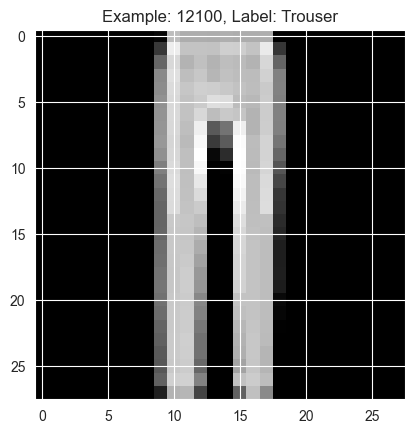

In [8]:
# image_id = 12100
# fashion_mnist_train_image, fashion_mnist_train_label = fashion_mnist_train_data[image_id]
#
# # define tensor to image transformation
# trans = torchvision.transforms.ToPILImage()
#
# # set image plot title
# plt.title('Example: {}, Label: {}'.format(str(image_id), fashion_classes[fashion_mnist_train_label]))
#
# # plot mnist handwritten digit sample
# plt.imshow(trans(fashion_mnist_train_image), cmap='gray')

In [9]:
# fashion_mnist_train_image.size()

torch.Size([1, 28, 28])

In [9]:
eval_path = data_directory + '/eval_fmnist'

# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_eval_data = torchvision.datasets.FashionMNIST(root=eval_path, train=False, transform=transf, download=True)

In [1]:
# len(fashion_mnist_eval_data)

# Model 1

For drawing: [http://alexlenail.me/NN-SVG/LeNet.html](http://alexlenail.me/NN-SVG/LeNet.html)

In [10]:
class FashionMNISTNet1(nn.Module):

    # define the class constructor
    def __init__(self):

        # call super class constructor
        super(FashionMNISTNet1, self).__init__()

        # specify convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=0)

        # define max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify fully-connected (fc) layer 1 - in 12*12*3, out 48
        self.linear1 = nn.Linear(12*12*3, 48, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity

        # specify fc layer 2 - in 48, out 10
        self.linear2 = nn.Linear(48, 10, bias=True) # the linearity W*x+b

        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax

    # define network forward pass
    def forward(self, images):
        # high-level feature learning via convolutional layers

        # define conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))

        #print(x.shape)

        # reshape image pixels
        x = x.view(-1, 12*12*3)

        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))

        # define layer 2 forward pass
        x = self.logsoftmax(self.linear2(x))

        # return forward pass result
        return x

## Model 1 Training

In [12]:
in_model1 = FashionMNISTNet1()
lr = 0.001
num_epochs = 10
mini_batch_size = 128
m1, min_epoch1, train_epoch_losses1 = model_training(in_model1, device, lr, num_epochs, mini_batch_size, fashion_mnist_train_data, models_directory)

[LOG] Training FashionMNISTNet1...
[LOG] Model architecture:

FashionMNISTNet1(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=432, out_features=48, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=48, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

[LOG] Number of to be trained FashionMNISTNet1 model parameters: 21352

[LOG 20230620-08:41:20] epoch: 0 train-loss: 2.292294509375273
[LOG 20230620-08:41:24] epoch: 1 train-loss: 2.2430409561596445
[LOG 20230620-08:41:28] epoch: 2 train-loss: 2.1132936780132465
[LOG 20230620-08:41:32] epoch: 3 train-loss: 1.8123945956036989
[LOG 20230620-08:41:36] epoch: 4 train-loss: 1.396532572408729
[LOG 20230620-08:41:39] epoch: 5 train-loss: 1.1150129794566108
[LOG 20230620-08:41:43] epoch: 6 train-loss: 0.9772441145707803
[LOG 20230620-08:41:46] epoch: 7 train-loss: 0.89987885634273

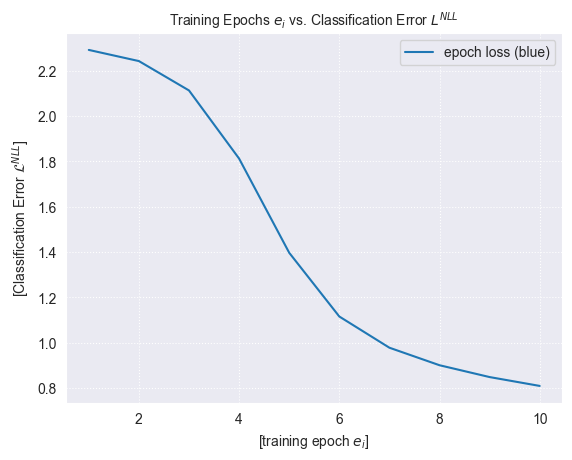

In [14]:
plot_training_loss(train_epoch_losses1)

In [15]:
# init pre-trained model class
best_model = FashionMNISTNet1()

path_to_best_model = '/content/drive/MyDrive/Colab Notebooks/models_fmnist/FashionMNIST10_model_epoch_19.pth'

[LOG 20230620-14:43:25] eval-loss: 0.8095473647117615


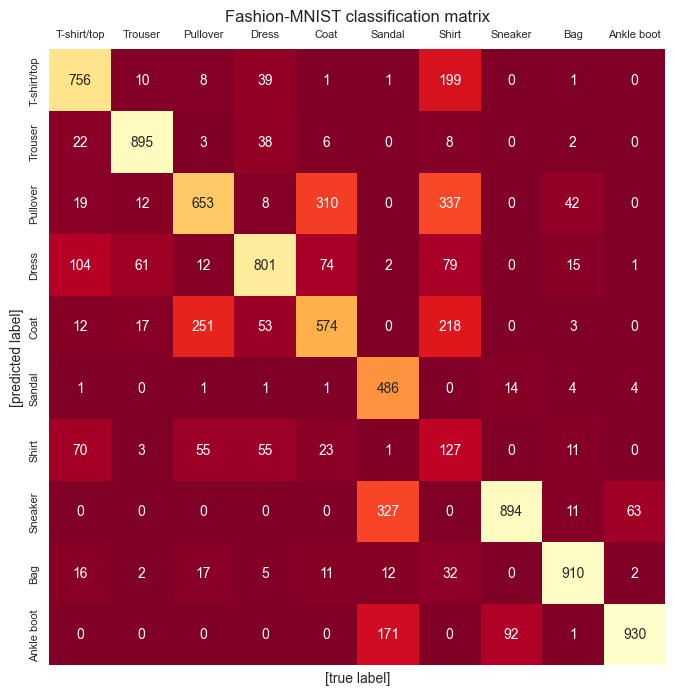

In [24]:
eval_loss1 = model_evaluation(best_model, './models_fmnist/FashionMNISTNet1_model_e10_mb128_lr1.0_epoch_9.pth', fashion_mnist_eval_data, 10000)